In [1]:
# Constants for you to change
import os

DATA_DIRECTORY = '/home/younes'
LIVEJOURNAL_FILENAME = os.path.join(DATA_DIRECTORY, 'amazon0302.txt.gz')
LIVEJOURNAL_URL = 'http://snap.stanford.edu/data/amazon0302.txt.gz'

# Just have these hardcoded, though we don't really need to
NUM_EDGES = 1234877
NUM_NODES = 262111

In [2]:
# Downloading the file

import urllib.request

assert os.path.exists(DATA_DIRECTORY)

# Get your data. This file is ~250M so it will take a bit
print('DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE')
if not os.path.exists(LIVEJOURNAL_FILENAME):
    urllib.request.urlretrieve(LIVEJOURNAL_URL, LIVEJOURNAL_FILENAME)

# Show a little bit of the file
print('\nFILE STATS:')
!ls -lh $LIVEJOURNAL_FILENAME
print('\nSTARTING LINES')
!zcat $LIVEJOURNAL_FILENAME | head -n 30

DOWNLOADING 250M FILE. WILL SAVE FOR FUTURE USE

FILE STATS:
-rw-rw-r-- 1 younes younes 4.5M ماي 19 01:53 /home/younes/amazon0302.txt.gz

STARTING LINES
# Directed graph (each unordered pair of nodes is saved once): Amazon0302.txt 
# Amazon product co-purchaisng network from March 02 2003
# Nodes: 262111 Edges: 1234877
# FromNodeId	ToNodeId
0	1
0	2
0	3
0	4
0	5
1	0
1	2
1	4
1	5
1	15
2	0
2	11
2	12
2	13
2	14
3	63
3	64
3	65
3	66
3	67
4	7
4	16
4	17
4	18
4	19
5	6

gzip: stdout: Broken pipe


In [3]:
# Cleaning the data

import numpy as np
import gzip

def row_generator():
    """This will generate all the edges in the graph."""
    with gzip.open(LIVEJOURNAL_FILENAME, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            else:
                (left_node, right_node) = line.split('\t')
                yield(int(left_node), int(right_node))

def to_undirected(edge_iterable, num_edges, num_nodes, shuffle=True):
    """Takes an iterable of edges and produces the list of edges for the undirected graph.
    
    > to_undirected([[0,1],[1,2],[2,10]], 3, 11)
    array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2, 10],
       [10,  2]])
    """
    # need int64 to do gross bithacks
    as_array = np.zeros((num_edges, 2), dtype=np.int64)
    for (i, (n_0, n_1)) in enumerate(edge_iterable):
            as_array[i,0] = n_0
            as_array[i,1] = n_1
    # The graph is directed, but we want to make it undirected,
    # which means we will duplicate some rows.

    left_nodes = as_array[:,0]
    right_nodes = as_array[:,1]
    
    if shuffle:
        the_shuffle = np.arange(num_nodes)
        np.random.shuffle(the_shuffle)
        left_nodes = the_shuffle.take(left_nodes)
        right_nodes = the_shuffle.take(right_nodes)

    
    # numpy.unique will not unique whole rows, so this little bit-hacking
    # is a quick way to get unique rows after making a flipped copy of
    # each edge.
    max_bits = int(np.ceil(np.log2(num_nodes + 1)))
    
    encoded_edges_forward = np.left_shift(left_nodes, max_bits) | right_nodes
    
    # Flip the columns and do it again:
    encoded_edges_reverse = np.left_shift(right_nodes, max_bits) | left_nodes

    unique_encoded_edges = np.unique(np.hstack((encoded_edges_forward, encoded_edges_reverse)))
    
    left_node_decoded = np.right_shift(unique_encoded_edges, max_bits)
    
    # Mask out the high order bits
    right_node_decoded = (2 ** (max_bits) - 1) & unique_encoded_edges
    
    undirected_edges = np.vstack((left_node_decoded, right_node_decoded)).T.astype(np.int32)

    # ascontiguousarray so that it's c-contiguous for cython code below
    return np.ascontiguousarray(undirected_edges)


def get_clean_data(shuffle=True):
    if shuffle:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned-shuffled.npy')
    else:
        name = os.path.join(DATA_DIRECTORY, 'LJ-cleaned.npy')

    if os.path.exists(name):
        print('Loading from file {}'.format(name))
        return np.load(name)
    else:
        print('Parsing from zip. Will write to file {}'.format(name), flush=True)
        # Lets get the edges into one big array
        edges = to_undirected(row_generator(), NUM_EDGES, NUM_NODES, shuffle=shuffle)
        print('ORIGINAL DIST: {} MIN: {} MAX: {}'.format(np.abs(edges[:,0] - edges[:,1]).mean(), edges.min(), edges.max()))
        np.save(name, edges)
        return edges

In [4]:
print("Normalizing data (or loaded pre-computed)")
%time edges = get_clean_data(shuffle=True)
%time unshuffled_edges = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Loading from file /home/younes/LJ-cleaned-shuffled.npy
CPU times: user 9.33 ms, sys: 6.63 ms, total: 16 ms
Wall time: 354 ms
Loading from file /home/younes/LJ-cleaned.npy
CPU times: user 14.1 ms, sys: 35.8 ms, total: 49.9 ms
Wall time: 1.11 s

EDGES SHAPE: (1799584, 2)


In [5]:
def score(assignment, edges):
    """Compute the score given an assignment of vertices.
    
    N nodes are assigned to clusters 0 to K-1.
    
    assignment: Vector where N[i] is the cluster node i is assigned to.
    edges: The edges in the graph, assumed to have one in each direction
    
    Returns: (total wasted bin space, ratio of edges cut)
    """
    balance = np.bincount(assignment) / len(assignment)
    waste = (np.max(balance) - balance).sum()
    
    left_edge_assignment = assignment.take(edges[:,0])
    right_edge_assignment = assignment.take(edges[:,1])
    mismatch = (left_edge_assignment != right_edge_assignment).sum()
    cut_ratio = mismatch / len(edges)
    return (waste, cut_ratio)

In [6]:
%load_ext cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
%%cython
import numpy as np
cimport cython

cdef int UNMAPPED = -1

def linear_deterministic_greedy(int[:,::] edges,
                                int num_nodes,
                                int num_partitions,
                                int[::] partition):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    edges: An [:,2] array of edges.
    num_nodes: The number of nodes in the graph.
    num_partitions: How many partitions we are breaking the graph into.
    partition: The partition from a previous run. Used for restreaming.

    Returns: A new partition.
    """
    # The output partition

    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)

    cdef int[::] partition_sizes = np.zeros(num_partitions, dtype=np.int32)
         
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    # Fine to be a little off, to stay integers
    cdef int partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef int max_val = 0
    cdef int val = 0
    cdef int len_edges = len(edges)
    
    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # We have found a new node so assign last_left to a partition
                
            max_arg = 0
            max_val = (partition_votes[0]) * (
                       partition_capacity - partition_sizes[0])

            for arg in range(1, num_partitions):
                val = (partition_votes[arg]) * (
                       partition_capacity - partition_sizes[arg])
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_val == 0:
                max_arg = arg
                # No neighbors (or multiple maxed out) so "randomly" select
                # the smallest partition
                for arg in range(i % num_partitions, num_partitions):
                    if partition_sizes[arg] < partition_capacity:
                        max_arg = arg
                        max_val = 1
                        break
                if max_val == 0:
                    for arg in range(0, i % num_partitions):
                        if partition_sizes[arg] < partition_capacity:
                            max_arg = arg
                            break


            partition_sizes[max_arg] += 1
            partition[last_left] = max_arg
            partition_votes[:] = 0
            last_left = left

        if partition[right] != UNMAPPED:
            partition_votes[partition[right]] += 1


    # Clean up the last assignment
    max_arg = 0
    max_val = 0
    for arg in range(0, num_partitions):
        if partition_sizes[arg] < partition_capacity:
            val = (partition_votes[arg]) * (
                    1 - partition_sizes[arg] / partition_capacity)
            if val > max_val:
                max_arg = arg
                max_val = val
    partition[left] = max_arg

    return np.asarray(partition)

In [10]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 2, assignments)

CPU times: user 23.3 ms, sys: 615 µs, total: 23.9 ms
Wall time: 25.1 ms


In [9]:
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))


edge score:0.18962826964454008 waste: 3.81517753927918e-06


In [11]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 4, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 23.7 ms
edge score:0.29644962391308216 waste: 1.90758876963959e-05


In [12]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 8, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 33.2 ms, sys: 96 µs, total: 33.3 ms
Wall time: 32.9 ms
edge score:0.3553543485605562 waste: 0.00015642227911083495


In [13]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 16, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 35.8 ms, sys: 620 µs, total: 36.4 ms
Wall time: 36.9 ms
edge score:0.3875640147945303 waste: 0.0007973721057109029


In [14]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 32, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 65.7 ms, sys: 0 ns, total: 65.7 ms
Wall time: 66.4 ms
edge score:0.405413695609652 waste: 0.0035442999339974496


In [15]:
assignments = None
%time partition = linear_deterministic_greedy(edges, NUM_NODES, 40, assignments)
(waste, edge_score) = score(partition, edges)
print("edge score:"+str(edge_score)+" waste: "+str(waste))

CPU times: user 62.9 ms, sys: 316 µs, total: 63.2 ms
Wall time: 62.7 ms
edge score:0.4085622010420186 waste: 0.004459942543426285


In [8]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('balance: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Edge cut')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [29]:
def run_restreaming_greedy(edges, num_nodes, num_partitions=10, num_iterations=10):
    print('\n{} PARTITIONS'.format(num_partitions))
    assignments = None
    print('ROUND\tWASTE\tSCORE')
    waste_values = []
    edge_score_values = []
    flipped_edges = numpy.flipud(edges).copy()
    for i in range(num_iterations):
        assignments = linear_deterministic_greedy(edges, NUM_NODES, num_partitions, assignments)
        (waste, edge_score) = score(assignments, edges)
        waste_values.append(waste)
        edge_score_values.append(edge_score)
        print('{}\t{:0.3f}\t{:0.3f}'.format(i, waste, edge_score))
    draw_figures(waste_values, edge_score_values, num_partitions)


4 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.296
1	0.000	0.216
2	0.000	0.197
3	0.000	0.190
4	0.000	0.187
5	0.000	0.185
6	0.000	0.184
7	0.000	0.183
8	0.000	0.183
9	0.000	0.183
10	0.000	0.183
11	0.000	0.183
12	0.000	0.183
13	0.000	0.182
14	0.000	0.182
15	0.000	0.182
16	0.000	0.182
17	0.000	0.182
18	0.000	0.182
19	0.000	0.182
CPU times: user 1.03 s, sys: 222 ms, total: 1.25 s
Wall time: 1.14 s


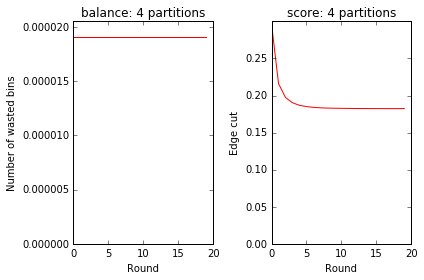

In [30]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=4, num_iterations=20)



8 PARTITIONS
ROUND	WASTE	SCORE
0	0.000	0.355
1	0.000	0.262
2	0.000	0.241
3	0.000	0.232
4	0.000	0.228
5	0.000	0.226
6	0.000	0.225
7	0.000	0.224
8	0.000	0.224
9	0.000	0.223
10	0.000	0.223
11	0.000	0.223
12	0.000	0.223
13	0.000	0.223
14	0.000	0.223
15	0.000	0.223
16	0.000	0.223
17	0.000	0.223
18	0.000	0.223
19	0.000	0.223
CPU times: user 1.17 s, sys: 394 ms, total: 1.57 s
Wall time: 1.29 s


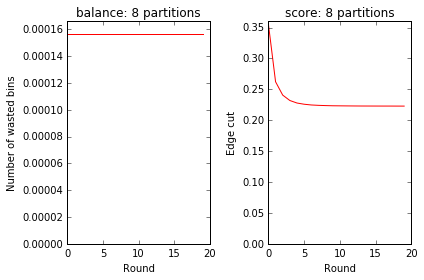

In [31]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=8, num_iterations=20)



16 PARTITIONS
ROUND	WASTE	SCORE
0	0.001	0.388
1	0.001	0.288
2	0.001	0.265
3	0.001	0.257
4	0.001	0.253
5	0.001	0.251
6	0.001	0.250
7	0.001	0.249
8	0.001	0.248
9	0.001	0.248
10	0.001	0.248
11	0.001	0.248
12	0.001	0.248
13	0.001	0.247
14	0.001	0.247
15	0.001	0.247
16	0.001	0.247
17	0.001	0.247
18	0.001	0.247
19	0.001	0.247
CPU times: user 1.21 s, sys: 221 ms, total: 1.43 s
Wall time: 1.32 s


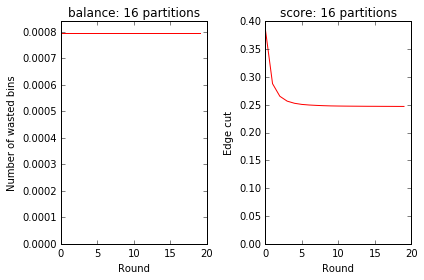

In [32]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=16, num_iterations=20)



32 PARTITIONS
ROUND	WASTE	SCORE
0	0.004	0.405
1	0.004	0.303
2	0.004	0.280
3	0.004	0.272
4	0.004	0.267
5	0.004	0.265
6	0.004	0.264
7	0.004	0.263
8	0.004	0.262
9	0.004	0.262
10	0.004	0.262
11	0.004	0.262
12	0.004	0.261
13	0.004	0.261
14	0.004	0.261
15	0.004	0.261
16	0.004	0.261
17	0.004	0.261
18	0.004	0.261
19	0.004	0.261
CPU times: user 1.52 s, sys: 258 ms, total: 1.77 s
Wall time: 1.63 s


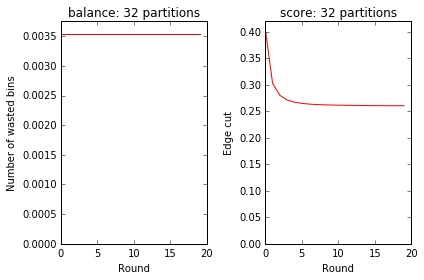

In [33]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=32, num_iterations=20)



40 PARTITIONS
ROUND	WASTE	SCORE
0	0.004	0.409
1	0.004	0.306
2	0.004	0.283
3	0.004	0.274
4	0.004	0.270
5	0.004	0.268
6	0.004	0.267
7	0.004	0.266
8	0.004	0.265
9	0.004	0.265
10	0.004	0.265
11	0.004	0.265
12	0.004	0.265
13	0.004	0.264
14	0.004	0.264
15	0.004	0.264
16	0.004	0.264
17	0.004	0.264
18	0.004	0.264
19	0.004	0.264
CPU times: user 1.64 s, sys: 236 ms, total: 1.87 s
Wall time: 1.75 s


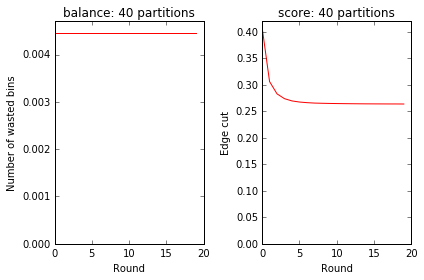

In [34]:
%time run_restreaming_greedy(edges, NUM_NODES, num_partitions=40, num_iterations=20)


In [9]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [25]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 29.8 ms
CPU times: user 25.8 ms, sys: 8.23 ms, total: 34.1 ms
Wall time: 32.2 ms
wast=1.0000038151775392 edge cut = 0.2401121592545833


In [30]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,2,assignment,1.00000015)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 33.5 ms, sys: 0 ns, total: 33.5 ms
Wall time: 33 ms
CPU times: user 29 ms, sys: 0 ns, total: 29 ms
Wall time: 27 ms
wast=1.0000038151775392 edge cut = 0.2401066024147803


In [31]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.00000015)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 32.2 ms, sys: 29 µs, total: 32.2 ms
Wall time: 32 ms
CPU times: user 30.6 ms, sys: 706 µs, total: 31.3 ms
Wall time: 27.3 ms
wast=1.0000190758876963 edge cut = 0.37336851183384606


In [36]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,4,assignment,1.000000000000854521)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 36 ms, sys: 2.87 ms, total: 38.9 ms
Wall time: 38.7 ms
CPU times: user 30.4 ms, sys: 0 ns, total: 30.4 ms
Wall time: 30.3 ms
wast=1.0000190758876963 edge cut = 0.373187358856269


In [37]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.000000000000854521)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 48.1 ms, sys: 3 µs, total: 48.1 ms
Wall time: 47.9 ms
wast=1.0000953794384821 edge cut = 0.4498250706830023


In [39]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,8,assignment,1.20)
%time wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 41.9 ms, sys: 0 ns, total: 41.9 ms
Wall time: 44.6 ms
CPU times: user 29.7 ms, sys: 0 ns, total: 29.7 ms
Wall time: 27 ms
wast=1.0000343365978537 edge cut = 0.5159792485374398


In [40]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.000000000000854521)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 64.9 ms, sys: 182 µs, total: 65 ms
Wall time: 65.2 ms
wast=1.0001259008587964 edge cut = 0.493005050056013


In [41]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,16,assignment,1.10)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 51.7 ms, sys: 0 ns, total: 51.7 ms
Wall time: 51.6 ms
wast=1.000064858018168 edge cut = 0.5673577893557622


In [42]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,32,assignment,1.000000000000854521)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 91.2 ms, sys: 0 ns, total: 91.2 ms
Wall time: 90.8 ms
wast=1.0002479865400535 edge cut = 0.5154524601241176


In [43]:
assignment = None
%time assignment = fennel(edges,NUM_NODES,40,assignment,1.000000000000854521)
wast,edge_cut = score(assignment, edges)
print('wast='+str(1+wast)+' edge cut = '+str(edge_cut))

CPU times: user 87.6 ms, sys: 901 µs, total: 88.5 ms
Wall time: 88.2 ms
wast=1.000492157902568 edge cut = 0.5201368760780269


In [26]:
def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(4.251608191745264e-05, 2.588951557309824e-02, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, NUM_NODES, num_partitions, assignments, 1.000001245)
        (waste, edge_score) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}'.format(i, alpha, waste, edge_score))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

# K = 2

2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.1e-06	0.000	0.240
1	5.1e-06	0.000	0.168
2	9.0e-06	0.000	0.145
3	1.3e-05	0.000	0.135
4	1.7e-05	0.000	0.129
5	2.1e-05	0.000	0.126
6	2.5e-05	0.000	0.123
7	2.9e-05	0.000	0.121
8	3.3e-05	0.000	0.120
9	3.7e-05	0.000	0.119
10	4.0e-05	0.000	0.119
11	4.4e-05	0.000	0.118
12	4.8e-05	0.000	0.118
13	5.2e-05	0.000	0.117
14	5.6e-05	0.000	0.117
15	6.0e-05	0.000	0.117
16	6.4e-05	0.000	0.117
17	6.8e-05	0.000	0.117
18	7.2e-05	0.000	0.117
19	7.6e-05	0.000	0.116
CPU times: user 1.38 s, sys: 249 ms, total: 1.63 s
Wall time: 1.49 s


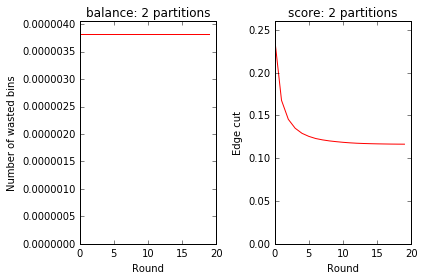

In [13]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


2 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.1e-04	0.000	0.240
1	5.1e-04	0.000	0.168
2	9.0e-04	0.000	0.145
3	1.3e-03	0.000	0.135
4	1.7e-03	0.000	0.129
5	2.1e-03	0.000	0.126
6	2.5e-03	0.000	0.123
7	2.9e-03	0.000	0.121
8	3.3e-03	0.000	0.120
9	3.7e-03	0.000	0.119
10	4.0e-03	0.000	0.119
11	4.4e-03	0.000	0.118
12	4.8e-03	0.000	0.118
13	5.2e-03	0.000	0.117
14	5.6e-03	0.000	0.117
15	6.0e-03	0.000	0.117
16	6.4e-03	0.000	0.117
17	6.8e-03	0.000	0.117
18	7.2e-03	0.000	0.117
19	7.6e-03	0.000	0.116
CPU times: user 1.32 s, sys: 275 ms, total: 1.6 s
Wall time: 1.46 s


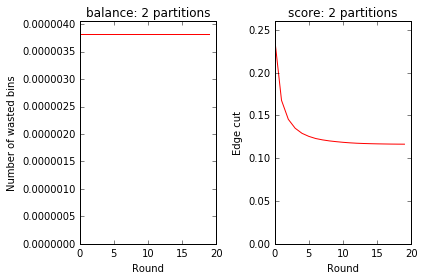

In [16]:
%time run_fennel_restreaming(edges, NUM_NODES, 2, 20)


# K = 8

8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.000	0.451
1	1.7e+00	0.000	0.323
2	2.2e+00	0.000	0.282
3	2.6e+00	0.000	0.262
4	3.1e+00	0.000	0.251
5	3.5e+00	0.000	0.244
6	4.0e+00	0.000	0.239
7	4.4e+00	0.000	0.235
8	4.9e+00	0.000	0.232
9	5.3e+00	0.000	0.229
10	5.8e+00	0.000	0.228
11	6.2e+00	0.000	0.226
12	6.7e+00	0.000	0.225
13	7.1e+00	0.000	0.224
14	7.6e+00	0.000	0.223
CPU times: user 1.17 s, sys: 62.4 ms, total: 1.23 s
Wall time: 1.13 s


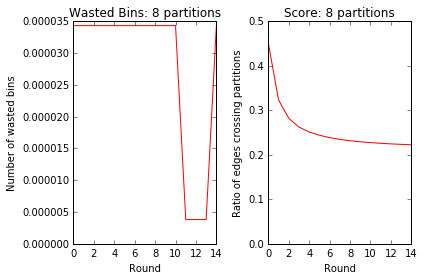

In [52]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 15)


8 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.1e-04	0.000	0.451
1	6.5e-04	0.000	0.323
2	1.2e-03	0.000	0.282
3	1.7e-03	0.000	0.262
4	2.2e-03	0.000	0.251
5	2.8e-03	0.000	0.244
6	3.3e-03	0.000	0.239
7	3.9e-03	0.000	0.235
8	4.4e-03	0.000	0.232
9	4.9e-03	0.000	0.229
10	5.5e-03	0.000	0.228
11	6.0e-03	0.000	0.226
12	6.5e-03	0.000	0.225
13	7.1e-03	0.000	0.224
14	7.6e-03	0.000	0.223
CPU times: user 1.17 s, sys: 201 ms, total: 1.37 s
Wall time: 1.26 s


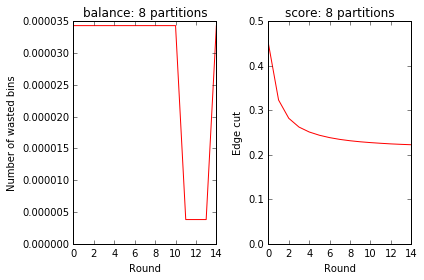

In [17]:
%time run_fennel_restreaming(edges, NUM_NODES, 8, 15)


# K= 16

16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.000	0.493
1	1.7e+00	0.000	0.356
2	2.2e+00	0.000	0.313
3	2.6e+00	0.000	0.293
4	3.1e+00	0.000	0.281
5	3.5e+00	0.000	0.273
6	4.0e+00	0.000	0.267
7	4.4e+00	0.000	0.263
8	4.9e+00	0.000	0.260
9	5.3e+00	0.000	0.257
10	5.8e+00	0.000	0.255
11	6.2e+00	0.000	0.253
12	6.7e+00	0.000	0.252
13	7.1e+00	0.000	0.251
14	7.6e+00	0.000	0.250
CPU times: user 1.26 s, sys: 83.5 ms, total: 1.34 s
Wall time: 1.24 s


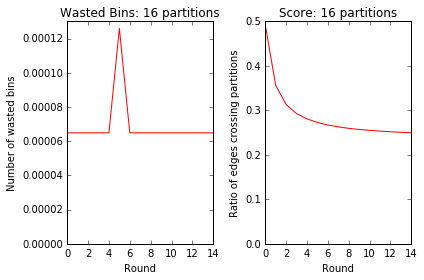

In [53]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 15)


16 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.1e-06	0.000	0.493
1	4.0e-02	0.000	0.356
2	8.0e-02	0.000	0.313
3	1.2e-01	0.000	0.293
4	1.6e-01	0.000	0.281
5	2.0e-01	0.000	0.273
6	2.4e-01	0.000	0.267
7	2.8e-01	0.000	0.263
8	3.2e-01	0.000	0.260
9	3.6e-01	0.000	0.257
10	4.0e-01	0.000	0.255
11	4.4e-01	0.000	0.253
12	4.8e-01	0.000	0.252
13	5.2e-01	0.000	0.251
14	5.6e-01	0.000	0.250
15	6.0e-01	0.000	0.249
16	6.4e-01	0.000	0.248
17	6.8e-01	0.000	0.247
18	7.2e-01	0.000	0.247
19	7.6e-01	0.000	0.246
CPU times: user 1.8 s, sys: 210 ms, total: 2.01 s
Wall time: 1.89 s


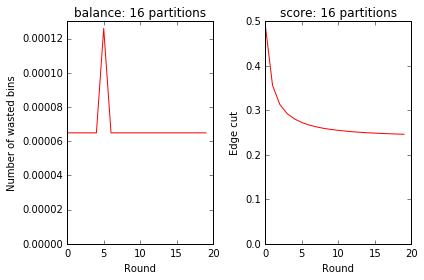

In [22]:
%time run_fennel_restreaming(edges, NUM_NODES, 16, 20)


# K=32

32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	1.3e+00	0.000	0.517
1	1.7e+00	0.000	0.374
2	2.2e+00	0.000	0.329
3	2.6e+00	0.000	0.308
4	3.1e+00	0.000	0.296
5	3.5e+00	0.000	0.288
6	4.0e+00	0.000	0.282
7	4.4e+00	0.000	0.278
8	4.9e+00	0.000	0.275
9	5.3e+00	0.000	0.273
10	5.8e+00	0.000	0.271
11	6.2e+00	0.000	0.269
12	6.7e+00	0.000	0.268
13	7.1e+00	0.000	0.266
14	7.6e+00	0.000	0.265
CPU times: user 1.59 s, sys: 100 ms, total: 1.69 s
Wall time: 1.55 s


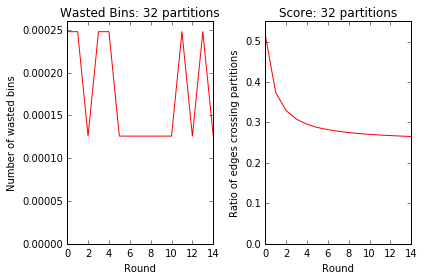

In [54]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 15)


32 PARTITIONS
ROUND	ALPHA	WASTE	SCORE
0	4.3e-05	0.000	0.517
1	1.4e-03	0.000	0.374
2	2.8e-03	0.000	0.329
3	4.1e-03	0.000	0.308
4	5.5e-03	0.000	0.296
5	6.8e-03	0.000	0.288
6	8.2e-03	0.000	0.282
7	9.6e-03	0.000	0.278
8	1.1e-02	0.000	0.275
9	1.2e-02	0.000	0.273
10	1.4e-02	0.000	0.271
11	1.5e-02	0.000	0.269
12	1.6e-02	0.000	0.268
13	1.8e-02	0.000	0.266
14	1.9e-02	0.000	0.265
15	2.0e-02	0.000	0.265
16	2.2e-02	0.000	0.264
17	2.3e-02	0.000	0.263
18	2.5e-02	0.000	0.263
19	2.6e-02	0.000	0.262
CPU times: user 1.82 s, sys: 277 ms, total: 2.1 s
Wall time: 1.98 s


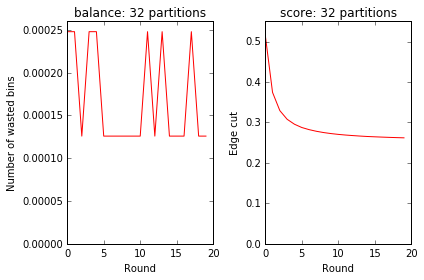

In [27]:
%time run_fennel_restreaming(edges, NUM_NODES, 32, 20)
